In [1]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data Preprocessing

In [2]:
DATA_PATH = os.path.realpath("../data/WESAD")

In [3]:
class Subject:
    """Subject of the WESAD dataset.
    Subject Class inspired by: https://github.com/WJMatthew/WESAD"""

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        """Returns data measured by the E4 Empatica"""

        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        """Returns data measured by the Respiband wristband"""
        return self.data['signal']['chest']
    
    def get_subject_dataframe(self):
        """Returns a dataframe with the preprocessed data of the subject"""
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        df = (df-df.min())/(df.max()-df.min()) # Normalize data (no train test leakage since data frame per subject)
        return df


In [4]:
# Create a dictionary with all the subjects and belonging dataframes
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
subjects_data = {}
for subject_num in subjects:
    subject = Subject(DATA_PATH, subject_num)
    subjects_data[subject.name] = subject.get_subject_dataframe()


### Window

In [5]:
# Subwindow length of the biosignals
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [6]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

In [7]:
def create_windows(df: pd.DataFrame) -> tuple[pd.DataFrame,list]:
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame

    Returns:
        tuple[pd.DataFrame,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

In [8]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.

    Returns:
        list: Subwindows of the signal in the window.
    """
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

In [9]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)
    

In [10]:
def average_window(subwindows_fft: list) -> list:
    """Calculates the average of the fft coefficients of the subwindows.

    Args:
        subwindows_fft (list): List of fft coefficients of the subwindows.

    Returns:
        list: Average of the fft coefficients of the subwindow for signals.
    """
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [13]:
# Creates averaged windows for all subjects from dataframes

subjects_preprosessed_data = {}
for subject_name, subject_df in subjects_data.items():
    subjects_preprosessed_data[subject_name] = {}
    windows, labels = create_windows(subject_df)
    yfs_per_min_for_signal = {}
    X = []
    for i in range(0,len(windows) - 1):
        for signal in signal_subwindow_dict.keys():

            duration_in_sec = signal_subwindow_dict[signal]

            subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
            freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
            yfs_average = average_window(yfs)[:210]
            yfs_per_min_for_signal[signal] = yfs_average
            
        X.append(pd.DataFrame(yfs_per_min_for_signal).T)
    y = list(labels[:len(windows)-1])
    subjects_preprosessed_data[subject_name]['X'] = X
    subjects_preprosessed_data[subject_name]['y'] = y


In [14]:
# Created train and test data for leave one out cross validation
all_subjects_X = []
all_subjects_y = []
for subject_name, subject_data in subjects_preprosessed_data.items():
    all_subjects_X.append(subject_data['X'])
    all_subjects_y.append(subject_data['y'])


# Model

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler

### Build model

In [18]:
def build_model(num_signals: int, num_output_class: int) -> tf.keras.models.Sequential:
    # Define the model architecture
    model = tf.keras.Sequential()
    # input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    # Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid', kernel_initializer='glorot_uniform')) # sigmoid statt softmax, da nur 2 Klassen

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Train model

In [19]:
groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset
num_signals = 6 # Number of signals in the WESAD dataset measured by the empatica e4
num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
num_epochs = 10

all_acc_histories = []
all_loss_histories = []

for i in groups_set:
    test_index = groups_set[i]
    train_index = [x for x in groups_set if x != test_index]
    print(train_index, test_index)

    X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
    y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))
    X_test = all_subjects_X[test_index]
    y_test = all_subjects_y[test_index]

    weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    #tf.keras.backend.clear_session()

    y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

    tf.keras.backend.clear_session()

    model = build_model(num_signals, num_output_class)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"models/wesad_binary_s{subject_ids[test_index]}_{num_epochs}.h5",  # Path to save the model file
        monitor="loss", # The metric name to monitor
        save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss",     # Quantity to be monitored.
        min_delta=0.01,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
        patience=10,        # Number of epochs with no improvement after which training will be stopped.
    )

    history = model.fit(
    X_train, 
    y_train,
    # validation_data=(X_test, y_test),
    epochs=num_epochs, 
    batch_size=50,
    verbose=1,
    class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
    callbacks = [checkpoint]#, early_stopping]
)   
    #acc_history = history.history['val_accuracy']
    #loss_history = history.history['val_loss']
    #all_acc_histories.append(acc_history)
    #all_loss_histories.append(loss_history)
    score = model.evaluate(X_test, y_test, verbose=0) 
    # print('Test loss:', round(score[0], 2)) 
    # print('Test accuracy:', round(score[1], 2))

    # test_loss.append(score[0])
    # test_acc.append(score[1])

    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 0


/var/folders/0x/2h0x6gds2qg6pxyf4w18xmcr0000gn/T/ipykernel_2665/3640312202.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
/var/folders/0x/2h0x6gds2qg6pxyf4w18xmcr0000gn/T/ipykernel_2665/3640312202.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))


Epoch 1/10
11/11 [==============================] - 8s 423ms/step - loss: 5.2781 - accuracy: 0.6392
Epoch 2/10
11/11 [==============================] - 5s 448ms/step - loss: 1.0270 - accuracy: 0.7784
Epoch 3/10
11/11 [==============================] - 5s 459ms/step - loss: 0.8590 - accuracy: 0.8098
Epoch 4/10
11/11 [==============================] - 5s 440ms/step - loss: 0.7770 - accuracy: 0.8412
Epoch 5/10
11/11 [==============================] - 5s 489ms/step - loss: 0.6776 - accuracy: 0.8216
Epoch 6/10
11/11 [==============================] - 5s 440ms/step - loss: 0.6792 - accuracy: 0.8176
Epoch 7/10
11/11 [==============================] - 5s 440ms/step - loss: 0.6302 - accuracy: 0.8627
Epoch 8/10
11/11 [==============================] - 5s 446ms/step - loss: 0.6235 - accuracy: 0.8431
Epoch 9/10
11/11 [==============================] - 5s 470ms/step - loss: 0.6011 - accuracy: 0.8569
Epoch 10/10
11/11 [==============================] - 5s 462ms/step - loss: 0.5952 - accuracy: 0.8569

# Evaluation

Evaluating every models on the corresponding test dataset not seen during training.

In [20]:
# Evaluating every models on the corresponding test dataset not seen during training.
all_accuracies = []
for i, subject_id in enumerate(subject_ids):
    X_test = all_subjects_X[i]
    y_test = all_subjects_y[i]
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
    
    model_path = f'models/wesad_binary_s{subject_id}_{num_epochs}.h5'

    model = tf.keras.models.load_model(model_path)
    accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
    all_accuracies.append(accuracy)

print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
print(f'Subject\t\t Accuracy')
print("**************************")
for i, accuracy in enumerate(all_accuracies):
    print(f'S{subject_ids[i]}\t\t {round(accuracy, 5)}')

print("**************************")
print(f'Avg. Accuracy:\t {round(np.mean(all_accuracies), 5)}')


Evaluation of CNN model trained on 10 epochs

Subject		 Accuracy
**************************
S2		 0.94286
S3		 0.71429
S4		 0.97222
S5		 1.0
S6		 0.94444
S7		 0.77778
S8		 0.91667
S9		 0.94444
S10		 0.94595
S11		 0.78378
S13		 1.0
S14		 0.51351
S15		 1.0
S16		 0.91892
S17		 0.64865
**************************
Avg. Accuracy:	 0.86823


<AxesSubplot:>

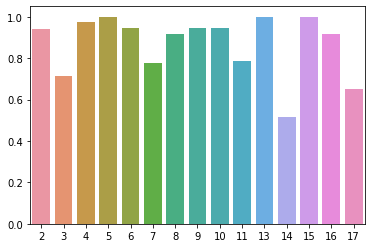

In [21]:
# bar plot of the accuracy of the different loso models
sns.barplot(x=subject_ids, y=all_accuracies)

# Prediction

In [24]:
model_path = "./models/wesad_binary_s17_10.h5"
model = tf.keras.models.load_model(model_path)
predictions = model.predict(X_test) # make predictions on the test set using the trained model
pred_class = np.argmax(predictions, axis=-1) # get the class with the highest probability

2/2 [==============================] - 0s 11ms/step


In [25]:
true_classified = 0
for i in range(len(pred_class)):
    print("Prediction: ", predictions[i])
    print("Prediction: ", pred_class[i])
    ground_truth = max(enumerate(y_test[i]),key=lambda x: x[1])[0]
    print("Ground Truth: ", ground_truth)
    print()
    if ground_truth == pred_class[i]:
        true_classified += 1
print("Accuracy: ", true_classified/len(pred_class))
    

Prediction:  [0.19653362 0.7266721 ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.2987437 0.563043 ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.41746154 0.43661615]
Prediction:  1
Ground Truth:  0

Prediction:  [0.48358414 0.38509127]
Prediction:  0
Ground Truth:  0

Prediction:  [0.57984984 0.30606028]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7080584  0.21673487]
Prediction:  0
Ground Truth:  0

Prediction:  [0.73444486 0.19104524]
Prediction:  0
Ground Truth:  0

Prediction:  [0.78660244 0.15906236]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7090117  0.16464692]
Prediction:  0
Ground Truth:  0

Prediction:  [0.85604537 0.10196819]
Prediction:  0
Ground Truth:  0

Prediction:  [0.8941529  0.07720542]
Prediction:  0
Ground Truth:  0

Prediction:  [0.91156244 0.06542813]
Prediction:  0
Ground Truth:  0

Prediction:  [0.8974828  0.08188976]
Prediction:  0
Ground Truth:  0

Prediction:  [0.88124657 0.091727  ]
Prediction:  0
Ground Truth:  0

Prediction:  [0.912030